In [37]:
%load_ext autoreload
%autoreload 2
import os
import sys
import math
from util.add_timestep import gen_test, Scoring_2008
from util.tcn import TemporalConvNet
from model import AE
# from util.model_torch import Gating,Encoder,EncoderLayer,MultiHeadAttention

import torch.nn.functional as F 
from torch.nn.modules import MSELoss
import torch
from torch import nn
from torch import Tensor
from torch import optim
from torchsummary import summary
from torch.utils.data import TensorDataset,DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('seaborn-whitegrid')#绘图的主题
plt.rcParams['font.sans-serif'] = 'Simsun'
plt.rcParams.update({'font.size': 12}) # 改变所有字体大小，改变其他性质类似

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


# 一.读取训练集

In [33]:
####制作表头
"""这个需要你自己再csv的数据中提前把与处理好的FFT或者2560维度的原始振动数据中手动添加UnitNumber和RUL"""
index_columns_names =  ["UnitNumber","RUL","ScaRUL"]##RUL做完了后自己先进行归一化，这样更加方便训练预测


features_colums = ['s' + str(i) for i in range(1, 2561)]###看你的数据维度，比如2560维度，那“67”就要改成2561
input_file_column_names = index_columns_names + features_colums

####归一的函数
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(0,1))
max_ab_scaler = MaxAbsScaler()

### 读取XJTU的前一步处理好的轴承数据

In [34]:
###这个是数据集的根目录，到时候你自己修改，我直接把
path_dir = "PHM2012/原始2560维振动数据/退化比例0.5/"

bearing1_1 = pd.read_csv(path_dir+'bearing1_1.csv', sep=",",
                       names=index_columns_names+features_colums,header=None) #'FFT_1_1_hor.csv'
                    #header=None表示第一行没有表头；=0表示第一行为表头
bearing1_1

,UnitNumber,RUL,ScaRUL,s1,s2,s3,s4,s5,s6,s7,...,s2551,s2552,s2553,s2554,s2555,s2556,s2557,s2558,s2559,s2560
0,1.0,1401.0,1.000000,0.552,0.501,0.138,-0.423,-0.802,-0.364,0.326,...,-0.478,-0.550,-0.186,0.426,0.451,0.044,-0.456,-0.885,-0.230,-0.134
1,1.0,1401.0,1.000000,-0.140,-0.162,-0.002,0.037,-0.085,0.016,0.380,...,-0.621,0.114,0.304,0.195,0.214,-0.391,-0.444,-0.306,0.082,0.669
2,1.0,1401.0,1.000000,0.207,-0.099,-0.151,-0.358,-0.424,0.119,0.072,...,0.253,0.619,-0.017,-0.086,-0.254,-0.300,-0.538,-0.544,-0.178,0.854
3,1.0,1401.0,1.000000,-0.071,0.050,-0.008,0.014,-0.533,-0.628,-0.140,...,-0.124,0.098,0.484,0.707,0.259,-0.575,-0.883,-0.387,0.341,0.664
4,1.0,1401.0,1.000000,-0.527,-0.192,0.118,0.320,0.484,0.402,-0.192,...,0.554,0.132,-0.924,-1.523,-1.448,-0.053,1.079,1.247,0.362,-0.701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2798,1.0,4.0,0.002855,1.246,0.292,0.021,-0.972,-2.489,-0.758,-3.847,...,2.263,2.244,3.018,0.455,1.768,-0.070,-0.482,-2.403,-1.070,-1.640
2799,1.0,3.0,0.002141,1.131,3.774,3.115,4.260,1.170,2.560,4.954,...,1.668,0.179,-0.414,1.271,0.924,0.273,-3.623,-0.623,-3.126,-3.269
2800,1.0,2.0,0.001428,-0.048,2.813,5.034,3.179,3.823,3.819,1.127,...,0.634,1.971,1.145,-1.019,1.207,-2.023,1.223,-1.724,-1.162,0.172
2801,1.0,1.0,0.000714,-7.488,-0.607,1.124,4.415,3.135,4.519,4.385,...,2.495,5.233,1.838,0.031,-4.444,-6.089,-5.275,-2.767,-1.224,-2.830


In [35]:
bearing1_2 = pd.read_csv(path_dir+'bearing1_2.csv', sep=",",
                       names=index_columns_names+features_colums,header=None) 
                    #header=None表示第一行没有表头；=0表示第一行为表头
bearing1_2

,UnitNumber,RUL,ScaRUL,s1,s2,s3,s4,s5,s6,s7,...,s2551,s2552,s2553,s2554,s2555,s2556,s2557,s2558,s2559,s2560
0,2.0,435.0,1.000000,0.050,0.165,0.125,0.157,0.421,0.683,0.656,...,0.214,-0.131,0.192,0.008,0.174,0.291,0.417,0.260,0.144,0.018
1,2.0,435.0,1.000000,-0.595,-0.508,-0.319,-0.080,0.167,0.028,-0.167,...,-0.611,-0.481,0.186,0.475,0.623,0.308,0.039,-0.136,-0.192,0.008
2,2.0,435.0,1.000000,0.599,0.297,0.241,-0.059,-0.119,0.099,0.458,...,1.304,0.913,-0.238,-0.395,-0.107,0.489,0.860,0.967,0.210,-0.659
3,2.0,435.0,1.000000,0.472,-0.604,-0.468,0.105,1.032,0.778,0.196,...,-1.175,-0.570,0.426,0.480,-0.221,-0.774,-0.592,-0.219,0.392,0.667
4,2.0,435.0,1.000000,0.956,1.536,0.864,-0.334,-1.457,-1.246,-0.742,...,0.616,0.508,0.080,-0.132,0.237,0.375,0.243,-0.100,-0.090,-0.284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,2.0,4.0,0.009195,2.711,-0.949,1.954,-0.624,1.141,-0.371,0.719,...,-0.858,-2.253,-1.087,0.548,1.428,-0.859,-0.992,-0.552,-1.206,2.158
867,2.0,3.0,0.006897,-0.511,-0.826,0.075,0.345,0.299,0.420,-0.807,...,0.119,-2.018,-2.127,1.261,1.389,-0.051,-1.479,-0.965,-3.019,-0.265
868,2.0,2.0,0.004598,-1.212,0.024,1.071,3.191,-1.669,-0.408,-1.374,...,0.879,1.619,-1.105,1.240,-2.467,1.312,0.511,2.518,1.506,1.701
869,2.0,1.0,0.002299,-0.552,-1.299,-3.705,0.783,2.084,0.247,-0.210,...,0.549,-0.006,-0.723,-1.589,0.888,0.050,0.307,-0.880,0.718,0.167


In [36]:
bearing1_3 = pd.read_csv(path_dir+'bearing1_3.csv', sep=",",
                       names=index_columns_names+features_colums,header=None) 
                    #header=None表示第一行没有表头；=0表示第一行为表头
bearing1_3

,UnitNumber,RUL,ScaRUL,s1,s2,s3,s4,s5,s6,s7,...,s2551,s2552,s2553,s2554,s2555,s2556,s2557,s2558,s2559,s2560
0,3.0,1187.0,1.000000,0.092,-0.025,-0.104,0.056,0.074,-0.147,-0.237,...,0.314,0.008,-0.292,0.050,0.447,0.491,-0.078,-0.595,-0.372,-0.178
1,3.0,1187.0,1.000000,0.356,0.272,-0.206,-0.355,-0.338,0.055,0.310,...,-0.435,-0.734,-0.468,0.536,1.261,0.352,-0.618,-1.293,-1.183,-0.450
2,3.0,1187.0,1.000000,0.692,0.751,0.646,-0.011,0.150,-0.185,-0.140,...,-0.032,-0.218,-0.019,0.022,-0.091,-0.170,0.180,0.821,0.895,0.205
3,3.0,1187.0,1.000000,0.769,0.668,0.173,-0.584,-0.630,-0.071,0.528,...,-0.112,-0.044,0.221,0.302,0.365,0.048,-0.528,-0.311,0.114,0.533
4,3.0,1187.0,1.000000,-0.431,0.225,0.417,0.986,0.652,0.250,-0.392,...,-0.176,0.208,0.592,0.380,0.183,-0.365,-0.486,-0.219,0.108,0.676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2370,3.0,4.0,0.003370,-8.072,1.650,-12.815,-21.361,-1.233,-6.789,3.270,...,-0.629,5.013,2.600,5.687,-4.560,2.152,-3.409,-0.849,-4.315,-6.751
2371,3.0,3.0,0.002527,5.094,-11.474,10.037,-8.775,14.037,-10.392,6.281,...,-6.384,-7.087,-9.097,0.452,-3.714,3.902,0.926,3.746,-0.685,-5.601
2372,3.0,2.0,0.001685,0.243,-0.812,-0.618,3.463,0.717,0.000,5.462,...,10.853,5.991,0.806,5.413,-1.487,-1.308,-2.120,-7.571,-5.540,-9.121
2373,3.0,1.0,0.000842,-6.276,-9.269,-15.043,-7.147,-6.716,-4.665,1.364,...,8.818,15.121,7.192,7.763,0.817,4.614,9.116,5.439,11.940,-0.891


In [11]:
bearing1_5 = pd.read_csv(path_dir+'bearing1_5.csv', sep=",",
                       names=index_columns_names+features_colums,header=None) 
                    #header=None表示第一行没有表头；=0表示第一行为表头
bearing1_5

,UnitNumber,RUL,ScaRUL,s1,s2,s3,s4,s5,s6,s7,...,s2551,s2552,s2553,s2554,s2555,s2556,s2557,s2558,s2559,s2560
0,5.0,1231.0,1.000000,0.211,0.268,0.306,0.226,-0.025,0.016,0.152,...,0.368,-0.742,-1.353,-0.851,0.371,1.200,0.596,-0.816,-1.165,-0.230
1,5.0,1231.0,1.000000,0.570,0.309,-0.016,-0.414,-0.600,-0.414,-0.253,...,-0.520,-0.315,-0.058,-0.057,-0.411,-0.891,-0.556,0.093,0.605,0.725
2,5.0,1231.0,1.000000,0.046,0.252,0.214,-0.021,-0.007,0.410,0.592,...,-0.092,0.036,0.584,0.844,0.799,0.032,-0.813,-0.281,0.128,0.355
3,5.0,1231.0,1.000000,0.064,-0.061,-0.145,0.227,0.117,-0.101,0.033,...,-0.622,-0.286,0.107,0.400,0.478,-0.114,-0.381,-0.185,0.567,0.600
4,5.0,1231.0,1.000000,-0.289,-0.335,0.174,0.070,-0.171,-0.293,-0.288,...,-0.257,-0.158,-0.081,-0.283,-0.453,-0.797,-0.698,-0.308,0.111,0.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458,5.0,4.0,0.003249,0.921,-0.700,0.421,0.581,0.783,0.261,0.382,...,-0.016,0.496,-0.611,0.936,-0.304,-0.103,0.039,-0.266,0.503,-1.095
2459,5.0,3.0,0.002437,0.238,-1.678,-0.005,-1.735,0.499,-0.171,0.420,...,0.431,-0.784,0.338,-0.724,-0.112,-0.268,-0.144,-0.383,-0.123,-0.785
2460,5.0,2.0,0.001625,0.272,-0.462,-0.865,-1.048,-0.410,-0.206,-0.711,...,-0.255,-0.769,0.346,0.215,-0.102,-0.229,0.159,0.193,-0.429,-0.040
2461,5.0,1.0,0.000812,0.027,-0.786,1.071,0.511,-0.730,-0.547,0.688,...,0.481,-1.062,-0.594,-1.612,-0.426,0.390,0.013,-0.230,-0.250,0.435


# 二.数据集制作

In [12]:
###要训练的轴承
# dataset=pd.concat([bearing1_1,bearing1_2,bearing1_3],axis=0)
# print(dataset.shape)
train_df = pd.concat([bearing1_1,bearing1_2], axis=0)
train_df
val_df=bearing1_3

In [13]:
###要测试的轴承
test_df = bearing1_5
test_df

,UnitNumber,RUL,ScaRUL,s1,s2,s3,s4,s5,s6,s7,...,s2551,s2552,s2553,s2554,s2555,s2556,s2557,s2558,s2559,s2560
0,5.0,1231.0,1.000000,0.211,0.268,0.306,0.226,-0.025,0.016,0.152,...,0.368,-0.742,-1.353,-0.851,0.371,1.200,0.596,-0.816,-1.165,-0.230
1,5.0,1231.0,1.000000,0.570,0.309,-0.016,-0.414,-0.600,-0.414,-0.253,...,-0.520,-0.315,-0.058,-0.057,-0.411,-0.891,-0.556,0.093,0.605,0.725
2,5.0,1231.0,1.000000,0.046,0.252,0.214,-0.021,-0.007,0.410,0.592,...,-0.092,0.036,0.584,0.844,0.799,0.032,-0.813,-0.281,0.128,0.355
3,5.0,1231.0,1.000000,0.064,-0.061,-0.145,0.227,0.117,-0.101,0.033,...,-0.622,-0.286,0.107,0.400,0.478,-0.114,-0.381,-0.185,0.567,0.600
4,5.0,1231.0,1.000000,-0.289,-0.335,0.174,0.070,-0.171,-0.293,-0.288,...,-0.257,-0.158,-0.081,-0.283,-0.453,-0.797,-0.698,-0.308,0.111,0.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458,5.0,4.0,0.003249,0.921,-0.700,0.421,0.581,0.783,0.261,0.382,...,-0.016,0.496,-0.611,0.936,-0.304,-0.103,0.039,-0.266,0.503,-1.095
2459,5.0,3.0,0.002437,0.238,-1.678,-0.005,-1.735,0.499,-0.171,0.420,...,0.431,-0.784,0.338,-0.724,-0.112,-0.268,-0.144,-0.383,-0.123,-0.785
2460,5.0,2.0,0.001625,0.272,-0.462,-0.865,-1.048,-0.410,-0.206,-0.711,...,-0.255,-0.769,0.346,0.215,-0.102,-0.229,0.159,0.193,-0.429,-0.040
2461,5.0,1.0,0.000812,0.027,-0.786,1.071,0.511,-0.730,-0.547,0.688,...,0.481,-1.062,-0.594,-1.612,-0.426,0.390,0.013,-0.230,-0.250,0.435


In [40]:
###时间步
sequence_length = 64
mask_value = 0
feats =['s' + str(i) for i in range(1, 1281)]
# feats = ['s' + str(i) for i in range(1, 67)]##需要的特征数据维度，可以自己选择

In [41]:
### 数据集归一化
"""先使用fit_transform,后使用transform"""

train_df[feats] = max_ab_scaler.fit_transform(train_df[feats])
val_df[feats]=max_ab_scaler.transform(val_df[feats])
test_df[feats] = max_ab_scaler.transform(test_df[feats])

### 训练集数据制作

In [42]:
#生成带时间步的三维数据，前面添加空行，滑动步长为1，制作原始样本长度各序列样本
x_train=np.concatenate(list(list(gen_test(train_df[train_df['UnitNumber']==unit], sequence_length, feats, mask_value)) 
                           for unit in train_df['UnitNumber'].unique()))#unique()获取唯一值
print(x_train.shape)
x_val=np.concatenate(list(list(gen_test(val_df[val_df['UnitNumber']==unit],sequence_length,feats,mask_value))
                         for unit in val_df['UnitNumber'].unique()))
print(x_val.shape)

(3674, 64, 1280)
(2375, 64, 1280)


In [43]:
#t获取训练集RUL标签
y_train = train_df.ScaRUL.values###这里的RUL是列名，如果不是这样命名要修改
y_train.shape


(3674,)

In [44]:
y_val=val_df.ScaRUL.values
y_val.shape

(2375,)

### 测试集数据制作

In [45]:
#生成带时间步的三维数据
x_test=np.concatenate(list(list(gen_test(test_df[test_df['UnitNumber']==unit], sequence_length, feats, mask_value)) 
                           for unit in test_df['UnitNumber'].unique()))
print(x_test.shape)

(2463, 64, 1280)


In [46]:
#t获取训练集RUL标签
y_test = test_df.ScaRUL.values
y_test.shape


(2463,)

### Torch中的数据形式转换

In [47]:
##需要验证集，请自己从x_train中随机划分0.1-0.3的样本作为验证集
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
#x_vaild
#y_vaild
x_val=torch.Tensor(x_val)
y_val=torch.Tensor(y_val)
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)

In [48]:
print("训练集的特征形状, x_train ：", x_train.shape)
print("训练集的标签形状, y_train ：", y_train.shape)
print("验证集的特征性状，x_val ：",x_val.shape)
print("验证集的标签形状，y_val ：",y_val.shape)
print("测试集的特征形状, x_test ：", x_test.shape)
print("测试集的标签形状, y_test ：", y_test.shape)

训练集的特征形状, x_train ： torch.Size([3674, 64, 1280])
训练集的标签形状, y_train ： torch.Size([3674])
验证集的特征性状，x_val ： torch.Size([2375, 64, 1280])
验证集的标签形状，y_val ： torch.Size([2375])
测试集的特征形状, x_test ： torch.Size([2463, 64, 1280])
测试集的标签形状, y_test ： torch.Size([2463])


In [49]:
data_train_loader=DataLoader(TensorDataset(x_train,y_train),batch_size=128,shuffle=False,
                            num_workers=0)
data_val_loader=DataLoader(TensorDataset(x_val,y_val),batch_size=128,shuffle=False,num_workers=0)


data_test_loader = DataLoader(TensorDataset(x_test,y_test),shuffle=False,
                             batch_size=128,num_workers=0)

# 三.构建Transformer模型

### 构建Transformer模型，注意，transformer、LTM模型的运行，需要注释掉以下代码。分别在Epoch_evaluate()、Last_evaluate2()、训练cell中的如下代码
 data = data.view(-1, input_channels, seq_length)#permute(0,2,1)#  
上述一步是Torch中卷积操作独有的，如果是LSTM可以注释掉这行代码  

In [71]:
class PositionalEncoding(nn.Module):
    #d_model数据特征维数，max_len最大序列长度
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

'''
将输入数据进行特征提取，添加位置信息传入Transformer

embedding_encoder:词嵌入模型，此处为autoencoder编码器
embedding_size:autoencoder输出特征维度
feature_size:Transformer输入特征维度(词嵌入输出维度)
'''
class Embedding(nn.Module):
    def __init__(self,embedding_encoder,embedding_size=32,feature_size=128,dropout=0.05):
        super(Embedding,self).__init__()
        self.embedding_encoder=embedding_encoder
        self.W_P=nn.Linear(embedding_size,feature_size)
        self.position=PositionalEncoding(feature_size)
        self.dropout=nn.Dropout()
    
    def forward(self,x):
        x=self.embedding_encoder(x) #进行特征提取
        x=self.W_P(x)
        x=self.position(x)#位置编码
        x=self.dropout(x)
        
        return x
        
       
"""这个就是transformer中的self attention的使用，这里是配合transformer中的Encoder一起使用"""
class Transforemer_Encoder(nn.Module):
    def __init__(self, embedding_encoder,embedding_size=32,feature_size=128, nhead=4,num_layers=2,dropout=0.2):
        super(Transforemer_Encoder, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.embedding=Embedding(embedding_encoder=embedding_encoder,embedding_size=embedding_size,feature_size=feature_size)
        #定义每一个解码器块的参数
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=nhead, dropout=dropout)
        #定义整个transformer解码器的层数
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.deco_output = nn.Linear(1,1)
        self.init_weights()
        

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask
#         #我觉得可以不要位置编码
#         src = self.pos_encoder(src)
        src=self.embedding(src)
        output = self.transformer_encoder(src,None)#, self.src_mask)
        output = self.decoder(output)
        output = self.deco_output(output[:,-1,:])
        return F.sigmoid(output)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [51]:
"""在model(test)之前，需要加上model.eval()，否则的话，有输入数据，即使不训练，它也会改变权值。
    这是model中含有BN层和Dropout所带来的的性质。
    eval()时，框架会自动把BN和Dropout固定住，不会取平均，而是用训练好的值，
    不然的话，一旦test的batch_size过小，很容易就会被BN层导致生成图片颜色失真极大！！！！！！
    在做one classification的时候，训练集和测试集的样本分布是不一样的，尤其需要注意这一点。
"""
##output.detach().cpu().numpy())#能缩短计算时间
def Epoch_evaluate(net,loader):
    net.eval()
    min_val_loss = 0.0
    val_rmse=0.0
    val_score=0.0
    i = 0
    preds = []
    true = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
#             data = data.view(-1, input_channels, seq_length)#permute(0,2,1)#
            #上述一步是Torch中卷积操作独有的，如果是LSTM，transformer可以注释掉这行代码
            
            output = net(data)
            output = output.squeeze(1)
            
            preds.append(output.detach().cpu().numpy())
            true.append(target.detach().cpu().numpy())
            
            min_val_loss +=Losses(output, target).item()
            i +=1
        min_val_loss = min_val_loss/i
        val_rmse = np.sqrt(min_val_loss)
        preds = np.concatenate(preds)
        true = np.concatenate(true)
#         val_score =np.float(Scoring_2008(true,preds))
        return round(min_val_loss,5),np.round(val_rmse,5)
    
#现在都是对的了
def Last_evaluate2(net,loader):
    net.eval()
    min_val_loss = 0.0
    np_mse=0.0
    preds = []
    true = []
    i=0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
#             data = data.view(-1, input_channels, seq_length)#permute(0,2,1)
               #上述一步是Torch中卷积操作独有的，如果是LSTM，transformer可以注释掉这行代码           
            output = net(data)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(target.detach().cpu().numpy())
            min_val_loss +=Losses(output, target).item()
            i+=1
        min_val_loss=min_val_loss/i
        preds = np.concatenate(preds)
        true = np.concatenate(true)
        return np.round(preds,4),np.round(true,5)

### Transformer 的self attention 模型实例化

In [87]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # [b, 784] => [b, 20]
        self.encoder = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU()
        )
        # [b, 20] => [b, 784]
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 1280),
            # nn.Sigmoid()
        )

    def forward(self, x):
        """
        :param x: [b, 1, 28, 28]
        :return:
        """
        batch_size = x.size(0)
        # flatten
        x = x.view(batch_size, 1280)
        # encoder
        x = self.encoder(x)
        # decoder
        x = self.decoder(x)
        # reshape
        x = x.view(batch_size,1280)

        return x, None
    
autoencoder=AE()
autoencoder.load_state_dict(torch.load("autoencoder_model.pth"))
for param in autoencoder.parameters():
    param.requires_grad=False
autoencoder.to(device)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=1280, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1280, bias=True)
  )
)

In [90]:
input_channels=x_train.shape[-1]
seq_length =sequence_length
epochs = 300
steps = 0

###设置transformer的基本参数
feature_size = 64  # 输入特征维度
nhead = 2  #  multi-head attention 的头数
num_layers = 2  # encoder layers 的层数
dropout = 0.25

# define and load model
model = Transforemer_Encoder(embedding_encoder=autoencoder.encoder,embedding_size=32,feature_size=feature_size,
                             nhead=nhead, num_layers=num_layers, dropout=dropout).to(device)

# initialize Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.5,patience=50,min_lr=0.001)###设置学习率下降策略，连续50次loss没有下降，学习率为原来的0.1倍，最小值为0.0001
Losses = nn.MSELoss()
#"""这一步是打印你的TCN模型，14为特征维度，轴承数据看你的特征列数"""
#summary(model,(sequence_length,input_channels))

epoch [1/300], loss:0.1087, val_loss:0.11406, val_RMSE:0.33773, lr:0.001


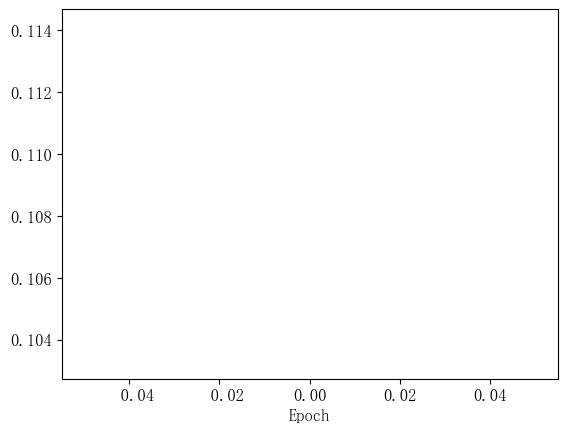

epoch [2/300], loss:0.1087, val_loss:0.11406, val_RMSE:0.33773, lr:0.001
epoch [3/300], loss:0.1087, val_loss:0.11406, val_RMSE:0.33773, lr:0.001
epoch [4/300], loss:0.1087, val_loss:0.11406, val_RMSE:0.33773, lr:0.001
epoch [5/300], loss:0.1087, val_loss:0.11407, val_RMSE:0.33774, lr:0.001
epoch [6/300], loss:0.1087, val_loss:0.11407, val_RMSE:0.33774, lr:0.001
epoch [7/300], loss:0.1087, val_loss:0.11407, val_RMSE:0.33774, lr:0.001
epoch [8/300], loss:0.1087, val_loss:0.11407, val_RMSE:0.33774, lr:0.001
epoch [9/300], loss:0.1087, val_loss:0.11407, val_RMSE:0.33774, lr:0.001
epoch [10/300], loss:0.1087, val_loss:0.11407, val_RMSE:0.33774, lr:0.001
epoch [11/300], loss:0.1088, val_loss:0.11407, val_RMSE:0.33774, lr:0.001
epoch [12/300], loss:0.1087, val_loss:0.11407, val_RMSE:0.33774, lr:0.001
epoch [13/300], loss:0.1087, val_loss:0.11407, val_RMSE:0.33774, lr:0.001
epoch [14/300], loss:0.1088, val_loss:0.11406, val_RMSE:0.33773, lr:0.001
epoch [15/300], loss:0.1087, val_loss:0.11406,

KeyboardInterrupt: 

In [93]:
%%time
###这个patience是连续150次，loss还是没有下降就停止运行
patience = 100
###这个是用于更新初始的val_loss的阈值
T_val_loss = 9999
counter = 0
train_loss= []
train_flood = []
val_loss = []
all_epochs = []
lr_step = []
###这个是模型权重的保存
save_dir="model/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

#动态绘制损失曲线
plt.ion()
fig,ax=plt.subplots()

    
for epoch in range(1, epochs+1):
    epoch_loss = 0
    flood_loss = 0
    model.train()
    for batch_idx,(data, target) in enumerate(data_train_loader):
        total = 0
        data, target = data.to(device), target.to(device)
        #data = data.view(-1, input_channels, seq_length)#permute(0,2,1)
        #上述一步是Torch中卷积操作独有的，如果是LSTM，transformer可以注释掉这行代码
    
        optimizer.zero_grad()
        output = model(data)
        output = output.squeeze(1)
        loss = Losses(output, target)
        loss.backward()
#         #这里添加梯度回退技巧，有一篇论文用到，你们可以试试
#         b = torch.Tensor([145]).to(device)
#         flood = (loss-b).abs()+b
#         flood.backward()
        optimizer.step()

        epoch_loss += loss.item()
#         flood_loss +=loss.item()
        total=batch_idx+1
    epoch_loss = epoch_loss/total
#     flood_loss = flood_loss/total
    ##############################还是要注意，不能把你要测试的数据放在这里进行验证####################################
    """不能使用是data_test_loader的数据作为  验证集，否则是算作弊
         需要做的办法：从训练集中随机，打乱抽取0.1-0.3的样本作为验证集 data_val_loader
         这个在TensorFlow中始很容易实现，但是Torch中我这一块没有研究，我自己代码是以TF2.X框架为主
         这个你们需要自己去查查，怎么制作新的validdata
    """
    min_val_loss ,val_rmse = Epoch_evaluate(model,data_val_loader) ###

    #学习率衰减策略 
    epoch_scheduler.step(min_val_loss)
    lr_current = optimizer.param_groups[0]['lr']
    lr_step.append(lr_current)
    
    print('epoch [{}/{}], loss:{:.4f}, val_loss:{}, val_RMSE:{}, lr:{}'.format(epoch,epochs,
                                                                        epoch_loss,min_val_loss,val_rmse,lr_current))#{:.4f}  
    ##这里是保存最后一个epoch的权重
    torch.save(model.state_dict(),os.path.join(save_dir, "model_on_last_epoch.pth"))
        
    if epoch % 1 == 0:
        train_loss.append(epoch_loss)
        val_loss.append(min_val_loss)
        all_epochs.append(epoch)
    """这里是设置训练的early stop patience """ 
    ax.clear()
    ax.plot(train_loss,'b')
    ax.set_xlabel('Epoch')
    plt.pause(0.1)
    #对测试集上的test_loss进行监视，并设置patience，保存在测试集上表现最好的model
    if T_val_loss >=min_val_loss:
        T_val_loss = min_val_loss
        #print("Saving...")
        best_epoch = epoch#找到最佳的epoch编号
        torch.save(model.state_dict(),os.path.join(save_dir, "model_onTestBest.pth"))
        counter = 0
    else: 
        counter += 1
    if counter == patience:
        break
    
    

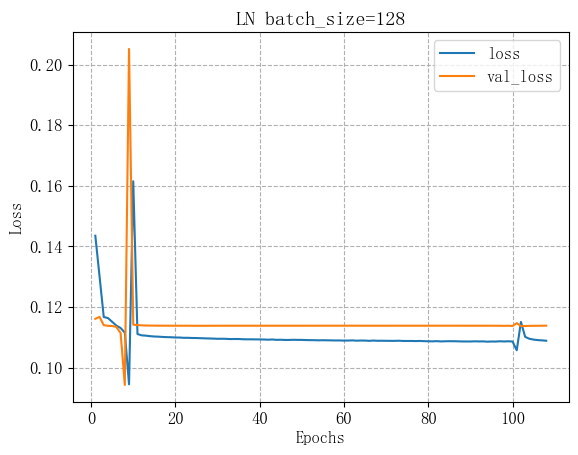

In [77]:
"""训练loss查看"""
#没有划分验证集，所以这个是测试集数据
plt.grid(linestyle="--")
plt.plot(all_epochs,train_loss)
plt.plot(all_epochs,val_loss)
plt.title('LN batch_size=128')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.savefig('model/loss.png' ,bbox_inches='tight', dpi=300)  # 600
plt.show()

In [78]:
"""评估"""
model.load_state_dict(torch.load(os.path.join(save_dir, "model_onTestBest.pth")))
train_metrics=[]
test_metrics =[]
train_metrics = Epoch_evaluate(model,data_train_loader)
test_metrics = Epoch_evaluate(model,data_test_loader) 
print('epoch [{}/{}], loss:{:.4f},     RMSE:{},'.format(best_epoch,epochs,train_metrics[0],train_metrics[1]))
print('epoch [{}/{}], val_loss:{:.4f}, val_RMSE:{}'.format(best_epoch,epochs,test_metrics[0],test_metrics[1]))

epoch [8/300], loss:0.0886,     RMSE:0.29772,
epoch [8/300], val_loss:0.1163, val_RMSE:0.34105


In [79]:
##保存评价指标：对于轴承
df = pd.DataFrame({'MSE':[train_metrics[0]] ,
                   'RMSE': [train_metrics[1]],})

df.transpose().to_csv("model/评估得分.txt",
                      mode='w',header=['train'],sep=' ',index=["MSE","RMSE"])
df = pd.DataFrame({'MSE':[test_metrics[0]] ,
                   'RMSE': [test_metrics[1]],})

df.transpose().to_csv("model/评估得分.txt",
                      mode='a',header=['test'],sep=' ',index=["MSE","RMSE"])

# 四.轴承RUL预测与可视化

## 训练集的预测

In [80]:
##训练集的预测
y_train_preds,y_train_true = Last_evaluate2(model,data_train_loader)

In [81]:
y_train_true.shape

(3674,)

In [82]:
"""保存预测的RUL值与实际的RUL值"""

y_train_All=pd.DataFrame({'Pre':y_train_preds,
                   'Actual':y_train_true})
y_train_All.to_csv("model/y_train_Pre.csv",
                      mode='w',header=["Pre","Actual"],sep=',',index=0)

## 测试集的预测

In [83]:
##测试集的预测
y_test_preds,y_test_true = Last_evaluate2(model,data_test_loader)

In [84]:
"""保存预测的RUL值与实际的RUL值"""

y_All=pd.DataFrame({'Pre':y_test_preds,
                   'Actual':y_test_true})
y_All.to_csv("model/y_test_Pre.csv",
                      mode='w',header=["Pre","Actual"],sep=',',index=0)

## 轴承的可视化以及RUL预测数据的保存

In [85]:
# 可视化
"""这里轴承的可视化，不包括ma、eam、SG滤波三种平滑方法，有兴趣自己添加或者再找我"""
"""这里以XJTU-SY_Bearing_Datasets\37.5Hz11kN的数据集为例
训练集:   Bearing2-1：长度491
              Bearing2-2：长度161
              Bearing2-3：长度533
测试集:   Bearing2-4：长度42
              Bearing2-5：长度339
"""
from sklearn.metrics import mean_squared_error

def calculateScore(y_pred, y_test):
    y_pred = list(map(lambda x: x[0], y_pred))
    return mean_squared_error(y_pred, y_test)

def plotUnitLines_y_test(y_test, y_pred, unit, Bpath='', figsize=[8, 6], plotname='', dirs=None):

    mse = mean_squared_error(y_test, y_pred)

    x = range(len(y_pred))

    data_list = []
   

    fig = plt.figure(figsize=figsize)
   
    plt.plot(x, y_pred, color="red", label='原始预测', linewidth=1)
    plt.plot(x, y_test, color='blue', label='实际值', linewidth=1)
    plt.xlim(0, max(x))
    plt.ylim(0, )
    plt.grid(linestyle="--")
    plt.title('Bearing1_' + str(unit) + ', MSE: ' + str('%.5f' % mse) ,
              fontsize=12)
    plt.ylabel('RUL(%)', fontsize=12)
    plt.xlabel('Running Time (*10s)', fontsize=12)
    plt.legend(fontsize=12)
    fig.tight_layout()

    if len(plotname) > 0:
        save_dir = dirs + Bpath
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(save_dir + plotname + ".png", bbox_inches='tight', dpi=300, format='png')  # 600
        np.savetxt(save_dir + plotname + "RULPre.csv", y_pred)
        np.savetxt(save_dir + plotname + "Act_RUL.csv", y_test)
        np.savetxt(save_dir + plotname + "x_axis.csv", x)
    plt.show()

## 注意用y_test_true和y_train_true绘图会出现锯齿

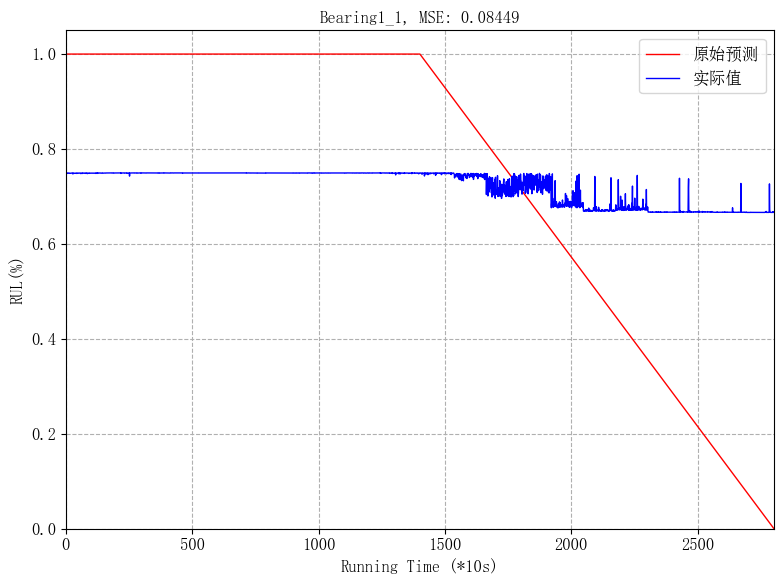

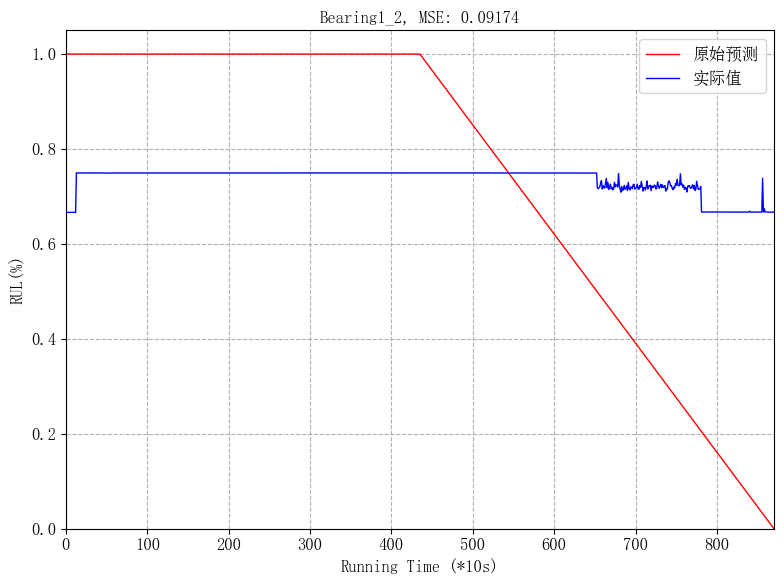

In [86]:
###训练集可视化
plotUnitLines_y_test(y_train_preds[:2803], y_train[:2803], unit=1, 
                     Bpath="best_epoch_result/B1_1/", figsize=[8, 6], plotname='B1_1_', dirs=save_dir)
plotUnitLines_y_test(y_train_preds[2803:2803+871], y_train[2803:2803+871], unit=2,
                     Bpath="best_epoch_result/B1_2/", figsize=[8, 6], plotname='B1_2_', dirs=save_dir)
# plotUnitLines_y_test(y_train_preds[491+161: 491+161+533], y_train[491+161: 491+161+533 ], unit=3,
#                      Bpath="best_epoch_result/B1_3/", figsize=[8, 6], plotname='B1_3_', dirs=save_dir)

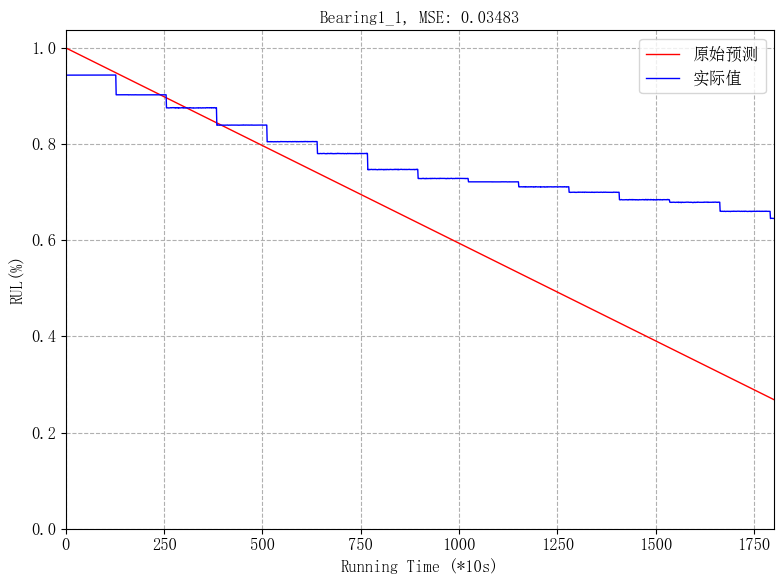

In [130]:
###测试集可视化
plotUnitLines_y_test(y_test_preds[:1802], y_test[:1802], unit=1, 
                     Bpath="best_epoch_result/B1_3/", figsize=[8, 6], plotname='B1_4_', dirs=save_dir)
# plotUnitLines_y_test(y_test_preds[42:42+339], y_test[42:42+339], unit=2,
#                      Bpath="best_epoch_result/B1_5/", figsize=[8, 6], plotname='B1_5_', dirs=save_dir)

### 上述图不是FFT和原始信号特征，效果果然不好，，，还是要在特征层面下足功夫